In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/azisu.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/szsyz.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/mesob.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/cmhsm.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/gofnj.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/wewoz.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/suuxu.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/spzmn.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/akthc.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/jiqvr.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/gwtwd.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/ufpel.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/usbgm.wav
/kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio/falxo.wav
/kaggle/input/voxcon

🎤 VoxConverse Diarization Pipeline - Kaggle Version
🚀 STARTING COMPLETE VOXCONVERSE DIARIZATION PIPELINE
📁 STEP 0: Understanding VoxConverse Dataset Structure
Checking dataset paths:
   Dev Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio
      Files found: 216
      Sample: azisu.wav
   Test Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_test_wav/voxconverse_test_wav
      Files found: 232
      Sample: fpfvy.wav
   Labels: ✓ /kaggle/input/voxconverse-dataset/labels/dev
      Files found: 216
      Sample: bwzyf.rttm

Dataset Statistics:
   Dev audio files: 216
   Test audio files: 232
   Label files: 216

Dataset Mapping Created:
   Matched audio-label pairs: 216
   Total speaker segments: 8268
   Average speakers per recording: 4.50
   Speaker count range: 1 - 20

Sample File Analysis (bwzyf):
   Speakers: 4
   Segments: 8
   Audio duration: 80.17 seconds
   Audio shape: (1282717,)


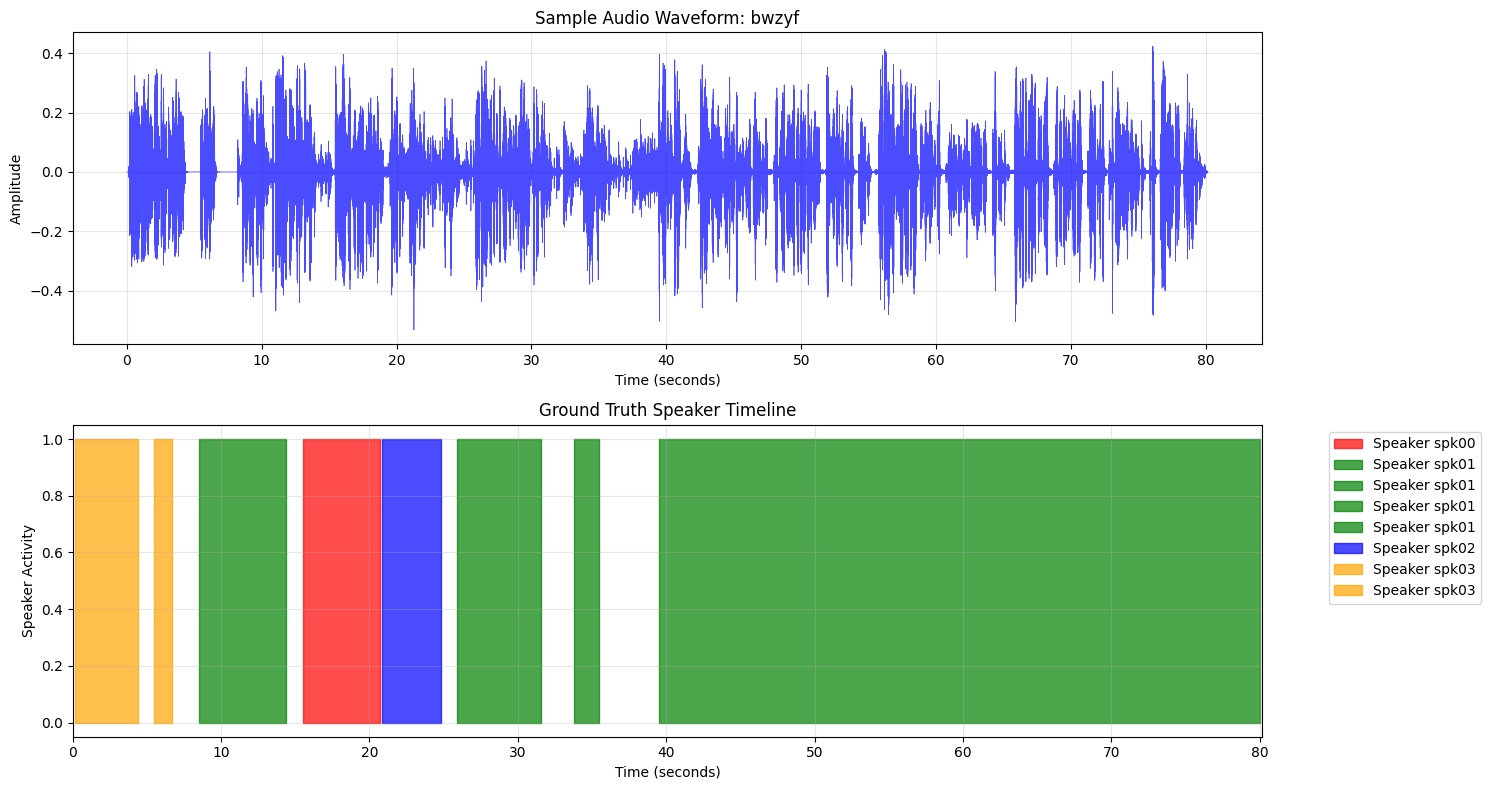


✅ Dataset structure analysis completed

🎵 STEP 1: Loading Real Audio from VoxConverse Dataset
Loading file: bwzyf


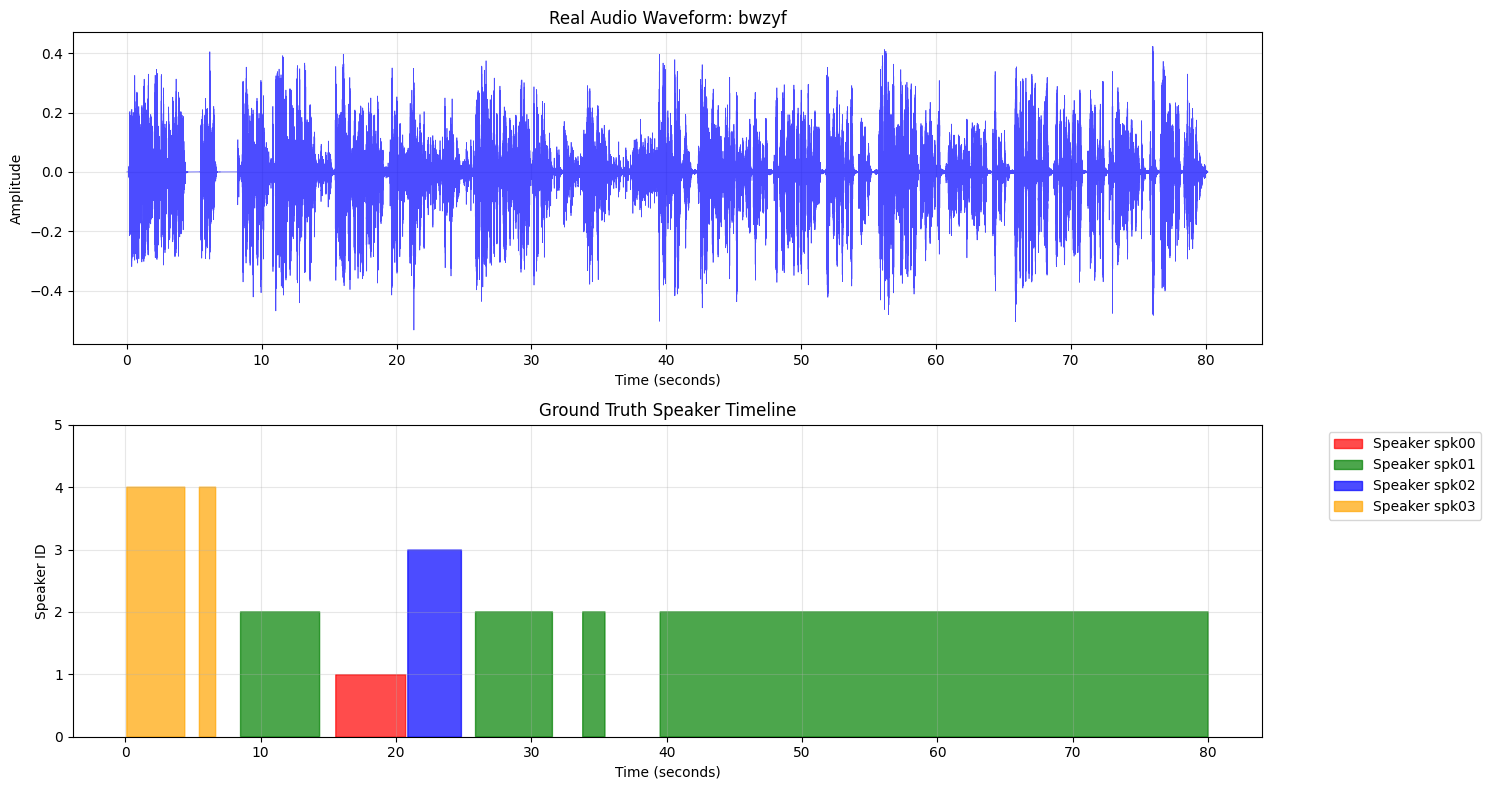

✅ Loaded audio: 80.17s, 4 speakers
   Speakers: ['spk00', 'spk01', 'spk02', 'spk03']
   Audio shape: (1282717,)

🎙️ STEP 2: Voice Activity Detection (VAD)


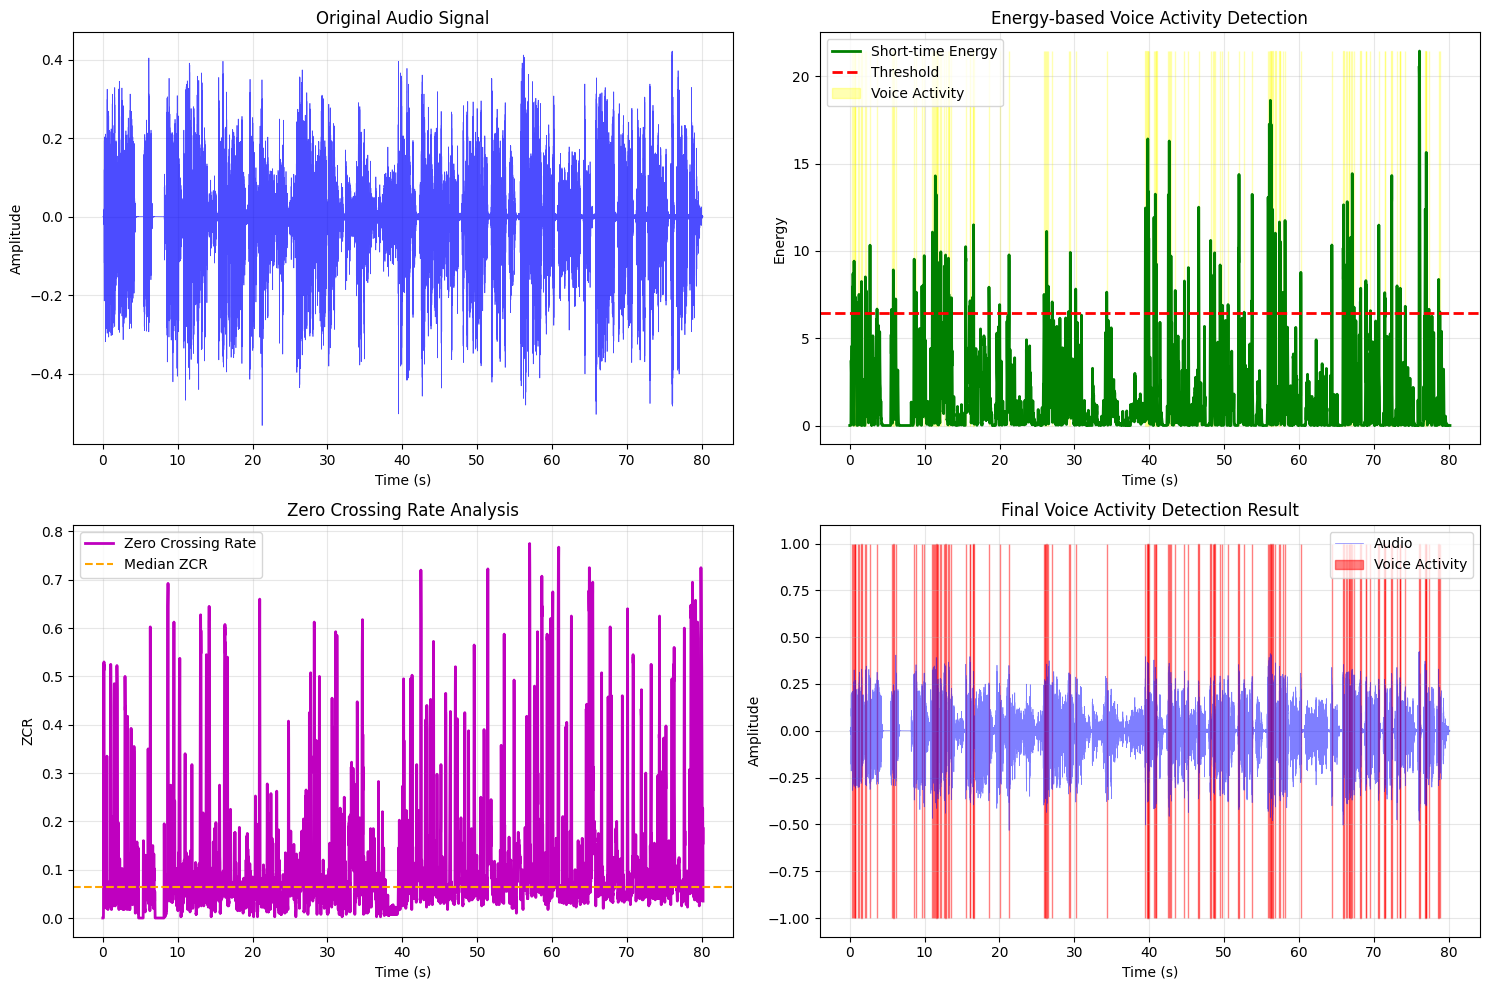

✅ Voice activity detected: 5.3% of the audio

🔍 STEP 3: Audio Feature Extraction
   Extracting features...


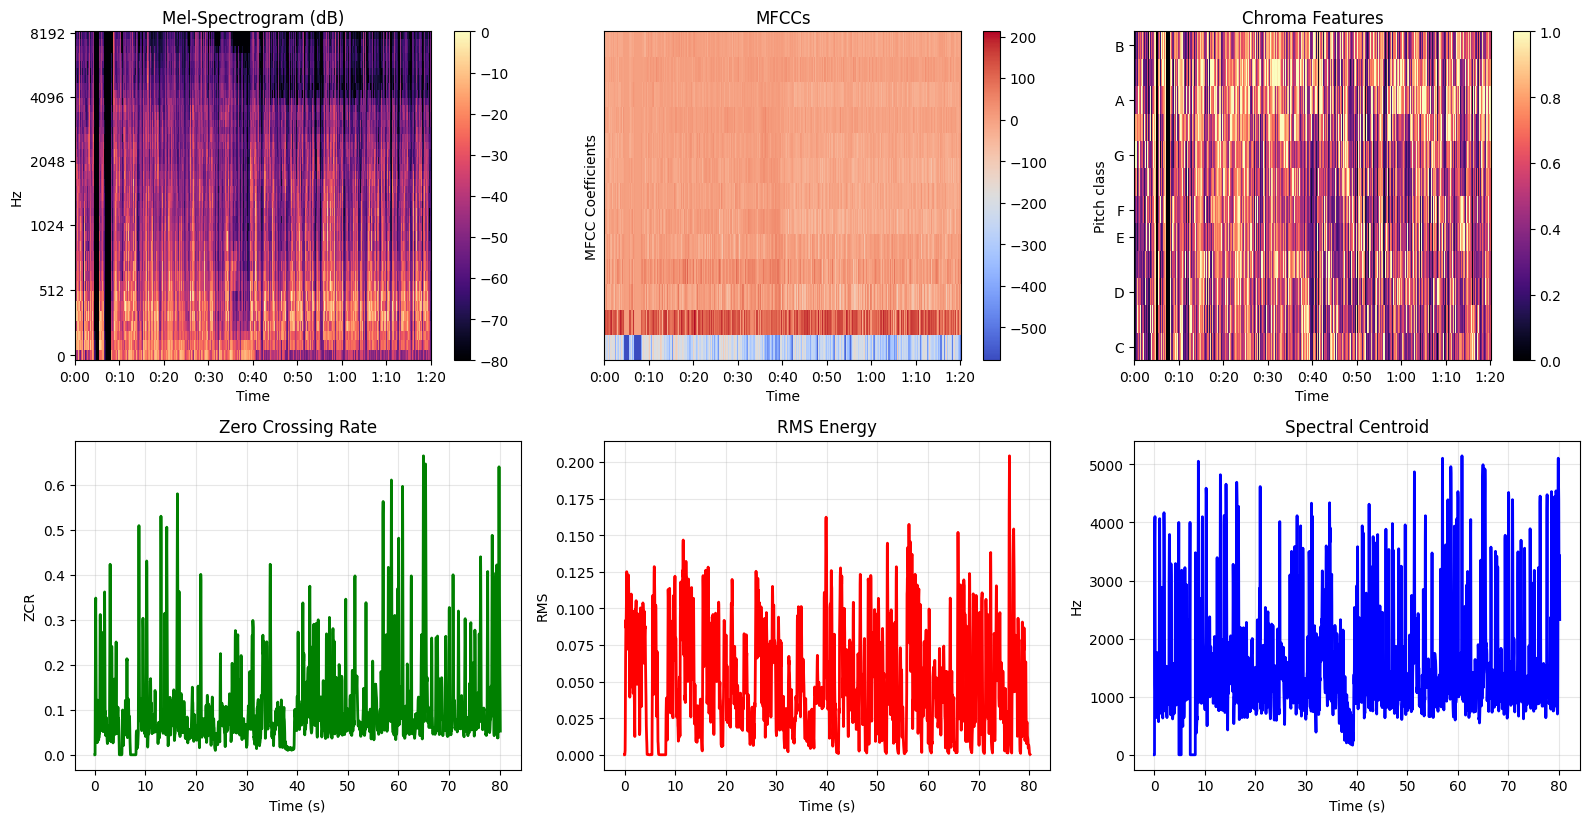

✅ Feature extraction completed
   MFCCs shape: (13, 2506)
   Feature time frames: 2506

👥 STEP 4: Creating Speaker Embeddings
✅ Speaker embeddings created
   Embedding shape: (97, 65)

🎯 STEP 5: Speaker Clustering


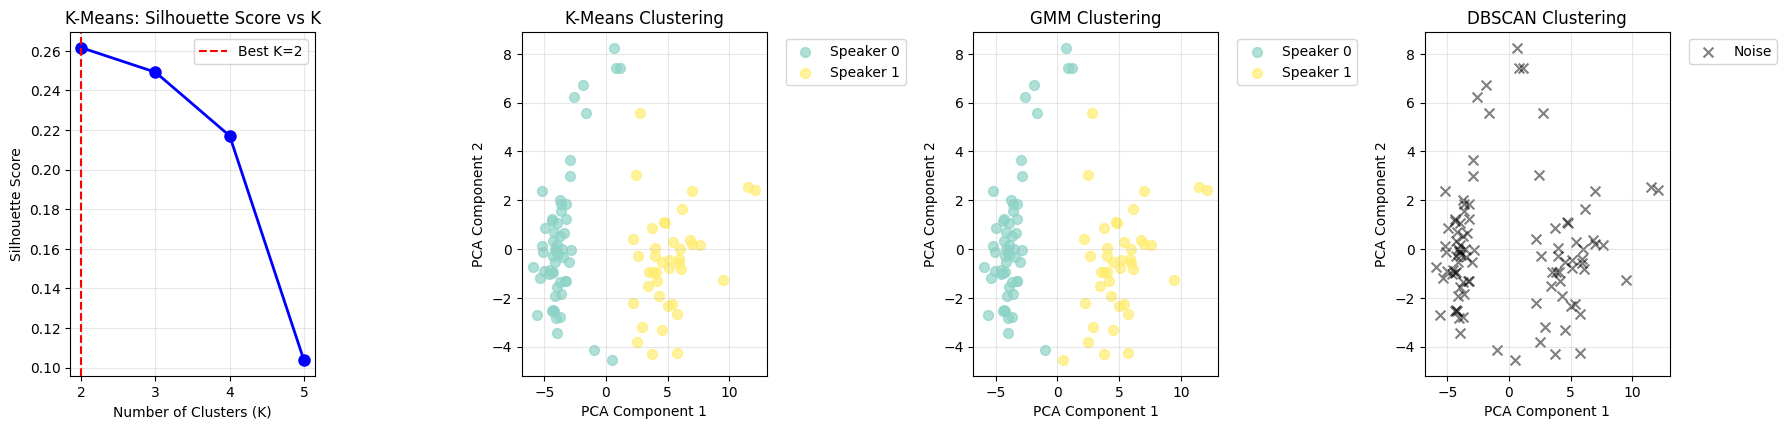

✅ Speaker clustering completed
   Best K-Means clusters: 2 (Silhouette score: 0.262)
   DBSCAN found 1 clusters

📊 STEP 6: Diarization Evaluation


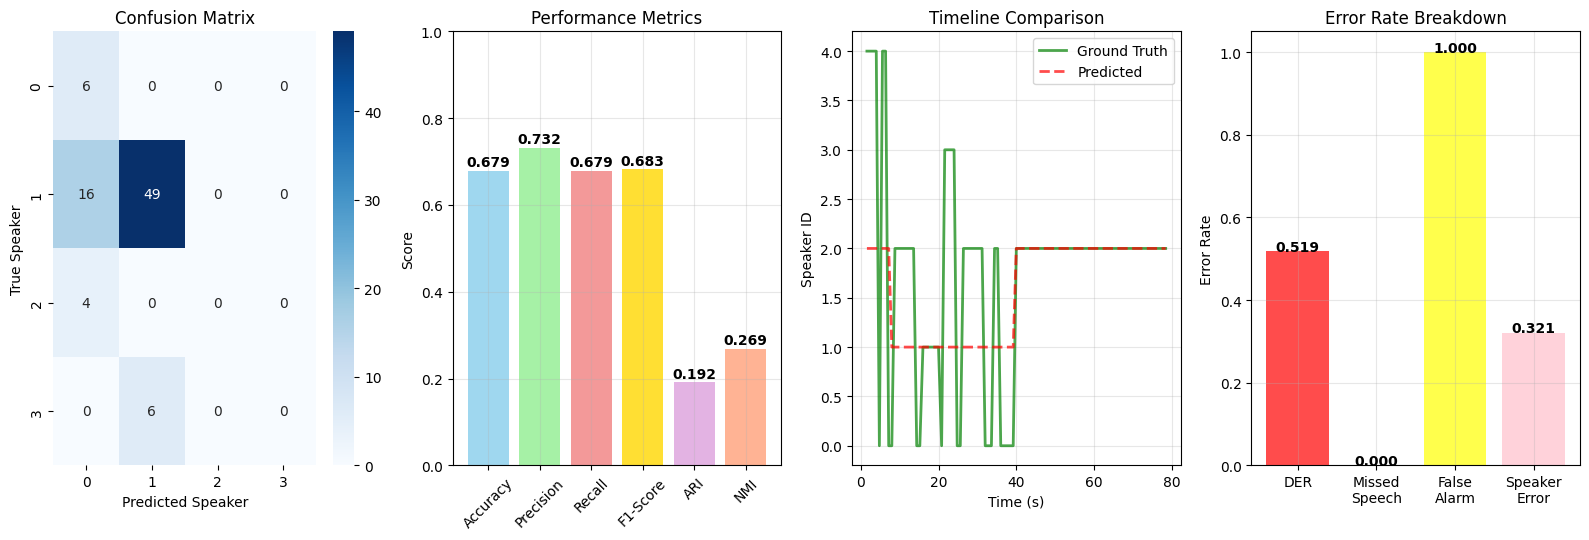

✅ Evaluation completed
   Overall Accuracy: 0.679
   F1-Score: 0.683
   Diarization Error Rate (DER): 0.519
   Adjusted Rand Index: 0.192

🎉 PIPELINE COMPLETED SUCCESSFULLY!
Summary of results:
   • Final Accuracy: 0.679
   • F1-Score: 0.683
   • Diarization Error Rate: 0.519


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import find_peaks
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                           precision_score, recall_score, f1_score, adjusted_rand_score, 
                           normalized_mutual_info_score, silhouette_score)
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

class VoxConverseDiarizationPipeline:
    def __init__(self, dataset_path="/kaggle/input/voxconverse-dataset", sr=16000):
        """
        Initialize the VoxConverse diarization pipeline
        """
        self.dataset_path = dataset_path
        self.sr = sr
        self.audio = None
        self.duration = None
        self.features = None
        self.speaker_labels = None
        self.vad_segments = None
        self.dataset_mapping = []
        
    def understand_dataset_structure(self):
        """
        STEP 0: Understand and analyze the VoxConverse dataset structure
        """
        print("📁 STEP 0: Understanding VoxConverse Dataset Structure")
        print("=" * 60)
        
        # Define paths
        dev_audio_path = Path(self.dataset_path) / "voxconverse_dev_wav" / "audio"
        test_audio_path = Path(self.dataset_path) / "voxconverse_test_wav" / "voxconverse_test_wav"
        labels_path = Path(self.dataset_path) / "labels" / "dev"
        
        # Check if paths exist
        paths_info = {
            "Dev Audio": dev_audio_path,
            "Test Audio": test_audio_path,
            "Labels": labels_path
        }
        
        print("Checking dataset paths:")
        for name, path in paths_info.items():
            exists = path.exists()
            print(f"   {name}: {'✓' if exists else '✗'} {path}")
            if exists:
                files = list(path.glob("*.*"))
                print(f"      Files found: {len(files)}")
                if files:
                    print(f"      Sample: {files[0].name}")
        
        # List all files
        dev_audio_files = list(dev_audio_path.glob("*.wav")) if dev_audio_path.exists() else []
        test_audio_files = list(test_audio_path.glob("*.wav")) if test_audio_path.exists() else []
        label_files = list(labels_path.glob("*.rttm")) if labels_path.exists() else []
        
        print(f"\nDataset Statistics:")
        print(f"   Dev audio files: {len(dev_audio_files)}")
        print(f"   Test audio files: {len(test_audio_files)}")
        print(f"   Label files: {len(label_files)}")
        
        # Parse RTTM files and create dataset mapping
        def parse_rttm(rttm_file):
            """Parse RTTM file to extract speaker segments"""
            segments = []
            with open(rttm_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 8 and parts[0] == 'SPEAKER':
                        file_id = parts[1]
                        start_time = float(parts[3])
                        duration = float(parts[4])
                        speaker_id = parts[7]
                        segments.append({
                            'file_id': file_id,
                            'start_time': start_time,
                            'duration': duration,
                            'end_time': start_time + duration,
                            'speaker_id': speaker_id
                        })
            return segments
        
        # Create dataset mapping
        self.dataset_mapping = []
        for rttm_file in label_files:
            file_id = rttm_file.stem
            
            # Find corresponding audio file
            audio_file = None
            for audio_path in [dev_audio_path, test_audio_path]:
                potential_audio = audio_path / f"{file_id}.wav"
                if potential_audio.exists():
                    audio_file = str(potential_audio)
                    break
            
            if audio_file:
                segments = parse_rttm(rttm_file)
                self.dataset_mapping.append({
                    'file_id': file_id,
                    'audio_path': audio_file,
                    'rttm_path': str(rttm_file),
                    'segments': segments,
                    'num_speakers': len(set(seg['speaker_id'] for seg in segments))
                })
        
        print(f"\nDataset Mapping Created:")
        print(f"   Matched audio-label pairs: {len(self.dataset_mapping)}")
        
        if self.dataset_mapping:
            # Analyze dataset statistics
            speaker_counts = [data['num_speakers'] for data in self.dataset_mapping]
            total_segments = sum(len(data['segments']) for data in self.dataset_mapping)
            
            print(f"   Total speaker segments: {total_segments}")
            print(f"   Average speakers per recording: {np.mean(speaker_counts):.2f}")
            print(f"   Speaker count range: {min(speaker_counts)} - {max(speaker_counts)}")
            
            # Sample file analysis
            sample_data = self.dataset_mapping[0]
            print(f"\nSample File Analysis ({sample_data['file_id']}):")
            print(f"   Speakers: {sample_data['num_speakers']}")
            print(f"   Segments: {len(sample_data['segments'])}")
            
            # Load sample audio for analysis
            try:
                sample_audio, _ = librosa.load(sample_data['audio_path'], sr=self.sr)
                print(f"   Audio duration: {len(sample_audio)/self.sr:.2f} seconds")
                print(f"   Audio shape: {sample_audio.shape}")
                
                # Visualize sample
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
                
                # Plot waveform
                time = np.arange(len(sample_audio)) / self.sr
                ax1.plot(time, sample_audio, 'b-', alpha=0.7, linewidth=0.5)
                ax1.set_title(f'Sample Audio Waveform: {sample_data["file_id"]}')
                ax1.set_xlabel('Time (seconds)')
                ax1.set_ylabel('Amplitude')
                ax1.grid(True, alpha=0.3)
                
                # Plot speaker timeline from RTTM
                colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray']
                speaker_colors = {}
                color_idx = 0
                
                for segment in sample_data['segments']:
                    speaker = segment['speaker_id']
                    if speaker not in speaker_colors:
                        speaker_colors[speaker] = colors[color_idx % len(colors)]
                        color_idx += 1
                    
                    ax2.fill_between([segment['start_time'], segment['end_time']], 0, 1,
                                   alpha=0.7, color=speaker_colors[speaker], 
                                   label = f'Speaker {speaker}' if speaker not in [h.get_label() for h in ax2.get_children() if hasattr(h, "get_label")] else None)
                
                ax2.set_title('Ground Truth Speaker Timeline')
                ax2.set_xlabel('Time (seconds)')
                ax2.set_ylabel('Speaker Activity')
                ax2.set_xlim(0, len(sample_audio)/self.sr)
                ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                ax2.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"   Could not load sample audio: {e}")
        
        else:
            print("   No matched pairs found. Check your dataset structure.")
            # Fallback to synthetic data
            print("\n⚠️  Falling back to synthetic data generation...")
            return self.generate_synthetic_data()
        
        print("\n✅ Dataset structure analysis completed")
        return self
    
    def load_real_audio(self, file_index=0):
        """
        Load real audio from VoxConverse dataset
        """
        print(f"\n🎵 STEP 1: Loading Real Audio from VoxConverse Dataset")
        print("=" * 60)
        
        if not self.dataset_mapping:
            print("❌ No dataset mapping available. Run understand_dataset_structure() first.")
            return self.generate_synthetic_data()
        
        # Load specific file
        if file_index >= len(self.dataset_mapping):
            file_index = 0
        
        sample_data = self.dataset_mapping[file_index]
        print(f"Loading file: {sample_data['file_id']}")
        
        try:
            # Load audio
            self.audio, _ = librosa.load(sample_data['audio_path'], sr=self.sr)
            self.duration = len(self.audio) / self.sr
            
            # Create ground truth labels
            self.ground_truth = np.zeros(len(self.audio))
            self.time = np.arange(len(self.audio)) / self.sr
            
            # Map speakers to integer labels
            unique_speakers = sorted(set(seg['speaker_id'] for seg in sample_data['segments']))
            speaker_to_id = {speaker: idx + 1 for idx, speaker in enumerate(unique_speakers)}
            
            for segment in sample_data['segments']:
                start_sample = int(segment['start_time'] * self.sr)
                end_sample = int(segment['end_time'] * self.sr)
                speaker_id = speaker_to_id[segment['speaker_id']]
                
                # Ensure we don't go out of bounds
                start_sample = max(0, min(start_sample, len(self.audio) - 1))
                end_sample = max(0, min(end_sample, len(self.audio)))
                
                self.ground_truth[start_sample:end_sample] = speaker_id
            
            # Store metadata
            self.current_file = sample_data
            self.speaker_mapping = speaker_to_id
            
            # Visualization
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
            
            # Plot waveform
            ax1.plot(self.time, self.audio, 'b-', alpha=0.7, linewidth=0.5)
            ax1.set_title(f'Real Audio Waveform: {sample_data["file_id"]}')
            ax1.set_xlabel('Time (seconds)')
            ax1.set_ylabel('Amplitude')
            ax1.grid(True, alpha=0.3)
            
            # Plot ground truth
            colors = ['white', 'red', 'green', 'blue', 'orange', 'purple']
            for speaker_id in range(1, len(unique_speakers) + 1):
                mask = self.ground_truth == speaker_id
                speaker_name = [k for k, v in speaker_to_id.items() if v == speaker_id][0]
                ax2.fill_between(self.time, 0, speaker_id, where=mask, alpha=0.7, 
                               color=colors[speaker_id % len(colors)], 
                               label=f'Speaker {speaker_name}')
            
            ax2.set_title('Ground Truth Speaker Timeline')
            ax2.set_xlabel('Time (seconds)')
            ax2.set_ylabel('Speaker ID')
            ax2.set_ylim(0, len(unique_speakers) + 1)
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print(f"✅ Loaded audio: {self.duration:.2f}s, {len(unique_speakers)} speakers")
            print(f"   Speakers: {list(unique_speakers)}")
            print(f"   Audio shape: {self.audio.shape}")
            
        except Exception as e:
            print(f"❌ Error loading real audio: {e}")
            print("Falling back to synthetic data...")
            return self.generate_synthetic_data()
        
        return self
    
    def generate_synthetic_data(self):
        """
        Generate synthetic multi-speaker audio data for demonstration
        """
        print("🎵 STEP 1: Generating Synthetic Multi-Speaker Audio Data")
        print("=" * 60)
        
        # Create synthetic audio with 3 speakers
        duration = 30  # seconds
        t = np.linspace(0, duration, duration * self.sr)
        
        # Speaker 1: Low frequency (male voice simulation)
        speaker1_times = [(0, 5), (10, 15), (20, 25)]
        # Speaker 2: Medium frequency (female voice simulation) 
        speaker2_times = [(3, 8), (13, 18), (23, 28)]
        # Speaker 3: High frequency (child voice simulation)
        speaker3_times = [(6, 11), (16, 21), (26, 30)]
        
        audio = np.zeros(len(t))
        ground_truth = np.zeros(len(t))
        
        # Generate speaker segments
        for start, end in speaker1_times:
            mask = (t >= start) & (t <= end)
            audio[mask] += 0.5 * (np.sin(2 * np.pi * 150 * t[mask]) + 
                                 0.3 * np.sin(2 * np.pi * 300 * t[mask]) + 
                                 0.2 * np.random.randn(np.sum(mask))) * np.exp(-0.1 * (t[mask] - start))
            ground_truth[mask] = 1
            
        for start, end in speaker2_times:
            mask = (t >= start) & (t <= end)
            audio[mask] += 0.4 * (np.sin(2 * np.pi * 250 * t[mask]) + 
                                 0.4 * np.sin(2 * np.pi * 500 * t[mask]) + 
                                 0.15 * np.random.randn(np.sum(mask))) * np.exp(-0.1 * (t[mask] - start))
            ground_truth[mask] = 2
            
        for start, end in speaker3_times:
            mask = (t >= start) & (t <= end)
            audio[mask] += 0.3 * (np.sin(2 * np.pi * 350 * t[mask]) + 
                                 0.5 * np.sin(2 * np.pi * 700 * t[mask]) + 
                                 0.1 * np.random.randn(np.sum(mask))) * np.exp(-0.1 * (t[mask] - start))
            ground_truth[mask] = 3
        
        # Add background noise
        audio += 0.05 * np.random.randn(len(t))
        audio = audio / np.max(np.abs(audio)) * 0.8
        
        self.audio = audio
        self.duration = duration
        self.ground_truth = ground_truth
        self.time = t
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
        
        ax1.plot(t, audio, 'b-', alpha=0.7, linewidth=0.5)
        ax1.set_title('Synthetic Multi-Speaker Audio Waveform')
        ax1.set_xlabel('Time (seconds)')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True, alpha=0.3)
        
        colors = ['white', 'red', 'green', 'blue']
        for speaker_id in [1, 2, 3]:
            mask = ground_truth == speaker_id
            ax2.fill_between(t, 0, speaker_id, where=mask, alpha=0.7, 
                           color=colors[speaker_id], label=f'Speaker {speaker_id}')
        
        ax2.set_title('Ground Truth Speaker Timeline')
        ax2.set_xlabel('Time (seconds)')
        ax2.set_ylabel('Speaker ID')
        ax2.set_ylim(0, 4)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Generated {duration}s audio with 3 speakers")
        return self
    
    def voice_activity_detection(self):
        """
        Detect voice activity in the audio signal
        """
        print("\n🎙️ STEP 2: Voice Activity Detection (VAD)")
        print("=" * 60)
        
        frame_length = int(0.025 * self.sr)
        hop_length = int(0.010 * self.sr)
        
        # Calculate short-time energy
        energy = []
        times = []
        
        for i in range(0, len(self.audio) - frame_length, hop_length):
            frame = self.audio[i:i + frame_length]
            frame_energy = np.sum(frame ** 2)
            energy.append(frame_energy)
            times.append(i / self.sr)
        
        energy = np.array(energy)
        times = np.array(times)
        
        threshold = np.mean(energy) + 2 * np.std(energy)
        voice_activity = energy > threshold
        
        zcr = librosa.feature.zero_crossing_rate(self.audio, 
                                               frame_length=frame_length,
                                               hop_length=hop_length)[0]
        # Make both arrays the same length
        min_len = min(len(voice_activity), len(zcr))
        voice_activity = voice_activity[:min_len]
        zcr = zcr[:min_len]

        combined_vad = voice_activity & (zcr < np.median(zcr) + np.std(zcr))
        
        self.vad_times = times
        self.vad_energy = energy
        self.vad_voice_activity = combined_vad
        
        # Visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        ax1.plot(self.time, self.audio, 'b-', alpha=0.7, linewidth=0.5)
        ax1.set_title('Original Audio Signal')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(times, energy, 'g-', linewidth=2, label='Short-time Energy')
        ax2.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold')
        ax2.fill_between(times, 0, np.max(energy), where=voice_activity, alpha=0.3, color='yellow', label='Voice Activity')
        ax2.set_title('Energy-based Voice Activity Detection')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Energy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        zcr_times = librosa.frames_to_time(np.arange(len(zcr)), sr=self.sr, hop_length=hop_length)
        ax3.plot(zcr_times, zcr, 'm-', linewidth=2, label='Zero Crossing Rate')
        ax3.axhline(y=np.median(zcr), color='orange', linestyle='--', label='Median ZCR')
        ax3.set_title('Zero Crossing Rate Analysis')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('ZCR')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        ax4.plot(self.time, self.audio, 'b-', alpha=0.5, linewidth=0.5, label='Audio')
        ax4.fill_between(times, -1, 1, where=combined_vad, alpha=0.5, color='red', label='Voice Activity')
        ax4.set_title('Final Voice Activity Detection Result')
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        voice_percentage = np.sum(combined_vad) / len(combined_vad) * 100
        print(f"✅ Voice activity detected: {voice_percentage:.1f}% of the audio")
        
        return self
    
    def extract_audio_features(self):
        """
        Extract comprehensive audio features for speaker characterization
        """
        print("\n🔍 STEP 3: Audio Feature Extraction")
        print("=" * 60)
        
        frame_length = 2048
        hop_length = 512
        n_mels = 40
        n_mfcc = 13
        
        print("   Extracting features...")
        
        stft = librosa.stft(self.audio, n_fft=frame_length, hop_length=hop_length)
        magnitude = np.abs(stft)
        
        mel_spec = librosa.feature.melspectrogram(y=self.audio, sr=self.sr, 
                                                n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        mfccs = librosa.feature.mfcc(y=self.audio, sr=self.sr, n_mfcc=n_mfcc,
                                   hop_length=hop_length)
        
        zcr = librosa.feature.zero_crossing_rate(self.audio, hop_length=hop_length)
        rms = librosa.feature.rms(y=self.audio, hop_length=hop_length)
        chroma = librosa.feature.chroma_stft(S=magnitude, sr=self.sr)
        spectral_centroids = librosa.feature.spectral_centroid(y=self.audio, sr=self.sr,
                                                             hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=self.audio, sr=self.sr,
                                                          hop_length=hop_length)
        
        self.features = {
            'stft': stft,
            'magnitude': magnitude,
            'mel_spec': mel_spec,
            'mel_spec_db': mel_spec_db,
            'mfccs': mfccs,
            'zcr': zcr,
            'rms': rms,
            'chroma': chroma,
            'spectral_centroids': spectral_centroids,
            'spectral_rolloff': spectral_rolloff
        }
        
        self.feature_times = librosa.frames_to_time(np.arange(mfccs.shape[1]), 
                                                   sr=self.sr, hop_length=hop_length)
        
        # Visualization
        fig = plt.figure(figsize=(16, 12))
        
        plt.subplot(3, 3, 1)
        librosa.display.specshow(mel_spec_db, sr=self.sr, hop_length=hop_length,
                               x_axis='time', y_axis='mel')
        plt.colorbar()
        plt.title('Mel-Spectrogram (dB)')
        
        plt.subplot(3, 3, 2)
        librosa.display.specshow(mfccs, sr=self.sr, hop_length=hop_length, x_axis='time')
        plt.colorbar()
        plt.title('MFCCs')
        plt.ylabel('MFCC Coefficients')
        
        plt.subplot(3, 3, 3)
        librosa.display.specshow(chroma, sr=self.sr, hop_length=hop_length,
                               x_axis='time', y_axis='chroma')
        plt.colorbar()
        plt.title('Chroma Features')
        
        plt.subplot(3, 3, 4)
        plt.plot(self.feature_times, zcr[0], 'g-', linewidth=2)
        plt.title('Zero Crossing Rate')
        plt.xlabel('Time (s)')
        plt.ylabel('ZCR')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 3, 5)
        plt.plot(self.feature_times, rms[0], 'r-', linewidth=2)
        plt.title('RMS Energy')
        plt.xlabel('Time (s)')
        plt.ylabel('RMS')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 3, 6)
        plt.plot(self.feature_times, spectral_centroids[0], 'b-', linewidth=2)
        plt.title('Spectral Centroid')
        plt.xlabel('Time (s)')
        plt.ylabel('Hz')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Feature extraction completed")
        print(f"   MFCCs shape: {mfccs.shape}")
        print(f"   Feature time frames: {len(self.feature_times)}")
        
        return self
    
    def create_speaker_embeddings(self):
        """
        Create speaker embeddings from extracted features
        """
        print("\n👥 STEP 4: Creating Speaker Embeddings")
        print("=" * 60)
        
        mfccs = self.features['mfccs']
        
        window_size = 100
        hop_size = 25
        
        embeddings = []
        embedding_times = []
        
        for i in range(0, mfccs.shape[1] - window_size, hop_size):
            window = mfccs[:, i:i + window_size]
            
            mean_features = np.mean(window, axis=1)
            std_features = np.std(window, axis=1)
            min_features = np.min(window, axis=1)
            max_features = np.max(window, axis=1)
            delta = np.mean(np.diff(window, axis=1), axis=1)
            
            embedding = np.concatenate([mean_features, std_features, 
                                      min_features, max_features, delta])
            
            embeddings.append(embedding)
            embedding_times.append(self.feature_times[i + window_size // 2])
        
        self.embeddings = np.array(embeddings)
        self.embedding_times = np.array(embedding_times)
        
        scaler = StandardScaler()
        self.embeddings_normalized = scaler.fit_transform(self.embeddings)
        
        pca = PCA(n_components=3)
        self.embeddings_pca = pca.fit_transform(self.embeddings_normalized)
        
        print(f"✅ Speaker embeddings created")
        print(f"   Embedding shape: {self.embeddings.shape}")
        
        return self
    
    def align_cluster_labels(self, pred_labels, true_labels):
        """
        Align predicted cluster labels with ground truth using Hungarian algorithm
        """
        unique_pred = np.unique(pred_labels)
        unique_true = np.unique(true_labels[true_labels > 0])
        
        if len(unique_pred) == 0 or len(unique_true) == 0:
            return pred_labels
        
        cost_matrix = np.zeros((len(unique_pred), len(unique_true)))
        
        for i, pred_label in enumerate(unique_pred):
            for j, true_label in enumerate(unique_true):
                mask_pred = pred_labels == pred_label
                mask_true = true_labels == true_label
                overlap = np.sum(mask_pred & mask_true)
                cost_matrix[i, j] = -overlap
        
        try:
            pred_indices, true_indices = linear_sum_assignment(cost_matrix)
            
            label_mapping = {}
            for pred_idx, true_idx in zip(pred_indices, true_indices):
                label_mapping[unique_pred[pred_idx]] = unique_true[true_idx]
            
            aligned_labels = np.array([label_mapping.get(label, 0) for label in pred_labels])
            return aligned_labels
        except:
            return pred_labels
    
    def perform_speaker_clustering(self):
        """
        Perform speaker clustering using multiple algorithms
        """
        print("\n🎯 STEP 5: Speaker Clustering")
        print("=" * 60)
        
        clustering_results = {}
        
        # K-Means clustering
        n_speakers_range = range(2, 6)
        kmeans_scores = []
        kmeans_models = {}
        
        for n_speakers in n_speakers_range:
            kmeans = KMeans(n_clusters=n_speakers, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.embeddings_normalized)
            score = silhouette_score(self.embeddings_normalized, labels)
            kmeans_scores.append(score)
            kmeans_models[n_speakers] = (kmeans, labels, score)
        
        best_k = n_speakers_range[np.argmax(kmeans_scores)]
        best_kmeans, kmeans_labels, best_score = kmeans_models[best_k]
        clustering_results['K-Means'] = kmeans_labels
        
        # Gaussian Mixture Model
        gmm = GaussianMixture(n_components=best_k, random_state=42)
        gmm_labels = gmm.fit_predict(self.embeddings_normalized)
        clustering_results['GMM'] = gmm_labels
        
        # DBSCAN clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan_labels = dbscan.fit_predict(self.embeddings_normalized)
        clustering_results['DBSCAN'] = dbscan_labels
        
        self.clustering_results = clustering_results
        self.best_clustering = clustering_results['K-Means']
        
        # Create ground truth for comparison
        ground_truth_labels = []
        for t in self.embedding_times:
            closest_idx = np.argmin(np.abs(self.time - t))
            ground_truth_labels.append(int(self.ground_truth[closest_idx]))
        
        self.ground_truth_labels = np.array(ground_truth_labels)
        
        # Visualization
        fig = plt.figure(figsize=(18, 12))
        
        # Elbow curve for K-Means
        plt.subplot(3, 4, 1)
        plt.plot(n_speakers_range, kmeans_scores, 'bo-', linewidth=2, markersize=8)
        plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best K={best_k}')
        plt.title('K-Means: Silhouette Score vs K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Clustering results in PCA space
        algorithms = ['K-Means', 'GMM', 'DBSCAN']
        for i, (alg_name, labels) in enumerate([(alg, clustering_results[alg]) for alg in algorithms]):
            plt.subplot(3, 4, i + 2)
            unique_labels = np.unique(labels)
            colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
            
            for label, color in zip(unique_labels, colors):
                mask = labels == label
                if label == -1:  # DBSCAN noise points
                    plt.scatter(self.embeddings_pca[mask, 0], self.embeddings_pca[mask, 1], 
                              c='black', marker='x', s=50, alpha=0.5, label='Noise')
                else:
                    plt.scatter(self.embeddings_pca[mask, 0], self.embeddings_pca[mask, 1], 
                              c=[color], s=50, alpha=0.7, label=f'Speaker {label}')
            
            plt.title(f'{alg_name} Clustering')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Speaker clustering completed")
        print(f"   Best K-Means clusters: {best_k} (Silhouette score: {best_score:.3f})")
        print(f"   DBSCAN found {len(np.unique(dbscan_labels))} clusters")
        
        return self
    
    def evaluate_diarization(self):
        """
        Evaluate diarization performance with comprehensive metrics
        """
        print("\n📊 STEP 6: Diarization Evaluation")
        print("=" * 60)
        
        # Align predicted labels with ground truth
        aligned_pred = self.align_cluster_labels(self.best_clustering, self.ground_truth_labels)
        
        # Create mask for voiced segments only
        voiced_mask = self.ground_truth_labels > 0
        
        if np.sum(voiced_mask) == 0:
            print("⚠️  No voiced segments found for evaluation")
            return self
        
        true_voiced = self.ground_truth_labels[voiced_mask]
        pred_voiced = aligned_pred[voiced_mask]
        
        # Calculate metrics
        accuracy = accuracy_score(true_voiced, pred_voiced)
        precision = precision_score(true_voiced, pred_voiced, average='weighted', zero_division=0)
        recall = recall_score(true_voiced, pred_voiced, average='weighted', zero_division=0)
        f1 = f1_score(true_voiced, pred_voiced, average='weighted', zero_division=0)
        ari = adjusted_rand_score(true_voiced, pred_voiced)
        nmi = normalized_mutual_info_score(true_voiced, pred_voiced)
        
        # Diarization Error Rate (DER)
        total_frames = len(voiced_mask)
        speech_frames = np.sum(voiced_mask)
        
        missed_speech = np.sum((self.ground_truth_labels > 0) & (aligned_pred == 0))
        false_alarm = np.sum((self.ground_truth_labels == 0) & (aligned_pred > 0))
        
        correct_speech_detection = (self.ground_truth_labels > 0) & (aligned_pred > 0)
        speaker_error = np.sum(correct_speech_detection & 
                              (self.ground_truth_labels != aligned_pred))
        
        der = (missed_speech + false_alarm + speaker_error) / max(speech_frames, 1)
        
        # Store metrics
        self.metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'adjusted_rand_index': ari,
            'normalized_mutual_info': nmi,
            'diarization_error_rate': der,
            'missed_speech_rate': missed_speech / max(speech_frames, 1),
            'false_alarm_rate': false_alarm / max(total_frames - speech_frames, 1),
            'speaker_error_rate': speaker_error / max(speech_frames, 1)
        }
        
        # Visualization
        fig = plt.figure(figsize=(16, 10))
        
        # Confusion matrix
        plt.subplot(2, 4, 1)
        cm = confusion_matrix(true_voiced, pred_voiced)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Speaker')
        plt.ylabel('True Speaker')
        
        # Metrics bar chart
        plt.subplot(2, 4, 2)
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ARI', 'NMI']
        metric_values = [accuracy, precision, recall, f1, ari, nmi]
        colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'lightsalmon']
        
        bars = plt.bar(metric_names, metric_values, color=colors, alpha=0.8)
        plt.title('Performance Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        
        for bar, value in zip(bars, metric_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', fontweight='bold')
        
        plt.grid(True, alpha=0.3)
        
        # Timeline comparison
        plt.subplot(2, 4, 3)
        plt.plot(self.embedding_times, self.ground_truth_labels, 'g-', alpha=0.7, linewidth=2, label='Ground Truth')
        plt.plot(self.embedding_times, aligned_pred, 'r--', alpha=0.7, linewidth=2, label='Predicted')
        plt.title('Timeline Comparison')
        plt.xlabel('Time (s)')
        plt.ylabel('Speaker ID')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Error breakdown
        plt.subplot(2, 4, 4)
        error_types = ['DER', 'Missed\nSpeech', 'False\nAlarm', 'Speaker\nError']
        error_rates = [der, self.metrics['missed_speech_rate'], 
                      self.metrics['false_alarm_rate'], self.metrics['speaker_error_rate']]
        
        bars = plt.bar(error_types, error_rates, color=['red', 'orange', 'yellow', 'pink'], alpha=0.7)
        plt.title('Error Rate Breakdown')
        plt.ylabel('Error Rate')
        
        for bar, value in zip(bars, error_rates):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{value:.3f}', ha='center', fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Evaluation completed")
        print(f"   Overall Accuracy: {accuracy:.3f}")
        print(f"   F1-Score: {f1:.3f}")
        print(f"   Diarization Error Rate (DER): {der:.3f}")
        print(f"   Adjusted Rand Index: {ari:.3f}")
        
        return self
    
    def run_full_pipeline(self, use_real_data=True, file_index=0):
        """
        Run the complete voice diarization pipeline
        """
        print("🚀 STARTING COMPLETE VOXCONVERSE DIARIZATION PIPELINE")
        print("=" * 80)
        
        # Execute all steps
        self.understand_dataset_structure()
        
        if use_real_data and self.dataset_mapping:
            self.load_real_audio(file_index)
        else:
            self.generate_synthetic_data()
        
        (self.voice_activity_detection()
             .extract_audio_features()
             .create_speaker_embeddings()
             .perform_speaker_clustering()
             .evaluate_diarization())
        
        print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print("Summary of results:")
        if hasattr(self, 'metrics'):
            print(f"   • Final Accuracy: {self.metrics['accuracy']:.3f}")
            print(f"   • F1-Score: {self.metrics['f1_score']:.3f}")
            print(f"   • Diarization Error Rate: {self.metrics['diarization_error_rate']:.3f}")
        
        return self

# Example usage for Kaggle environment
if __name__ == "__main__":
    print("🎤 VoxConverse Diarization Pipeline - Kaggle Version")
    print("=" * 60)
    
    # Initialize pipeline with your dataset path
    pipeline = VoxConverseDiarizationPipeline(dataset_path="/kaggle/input/voxconverse-dataset")
    
    # Run complete pipeline (will use real data if available, synthetic otherwise)
    pipeline.run_full_pipeline(use_real_data=True, file_index=0)

🚀 STARTING COMPLETE VOXCONVERSE DIARIZATION PIPELINE
📁 STEP 0: Understanding VoxConverse Dataset Structure
Checking dataset paths:
   Dev Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio
      Files found: 216
      Sample: azisu.wav
   Test Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_test_wav/voxconverse_test_wav
      Files found: 232
      Sample: fpfvy.wav
   Labels: ✓ /kaggle/input/voxconverse-dataset/labels/dev
      Files found: 216
      Sample: bwzyf.rttm

Dataset Statistics:
   Dev audio files: 216
   Test audio files: 232
   Label files: 216

Dataset Mapping Created:
   Matched audio-label pairs: 216
   Total speaker segments: 8268
   Average speakers per recording: 4.50
   Speaker count range: 1 - 20

Sample File Analysis (bwzyf):
   Speakers: 4
   Segments: 8
   Audio duration: 80.17 seconds
   Audio shape: (1282717,)


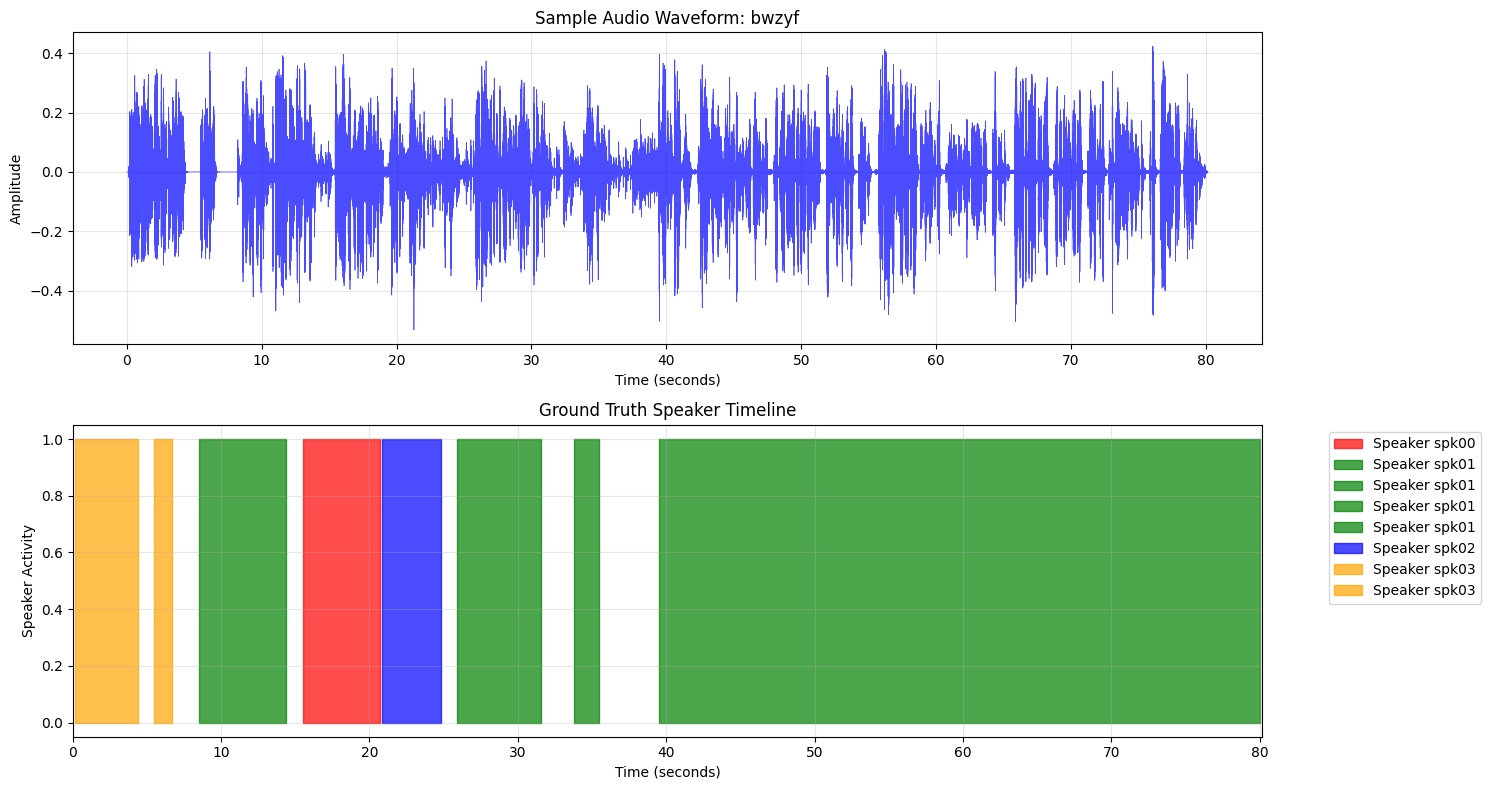


✅ Dataset structure analysis completed

🎵 STEP 1: Loading Real Audio from VoxConverse Dataset
Loading file: bwzyf


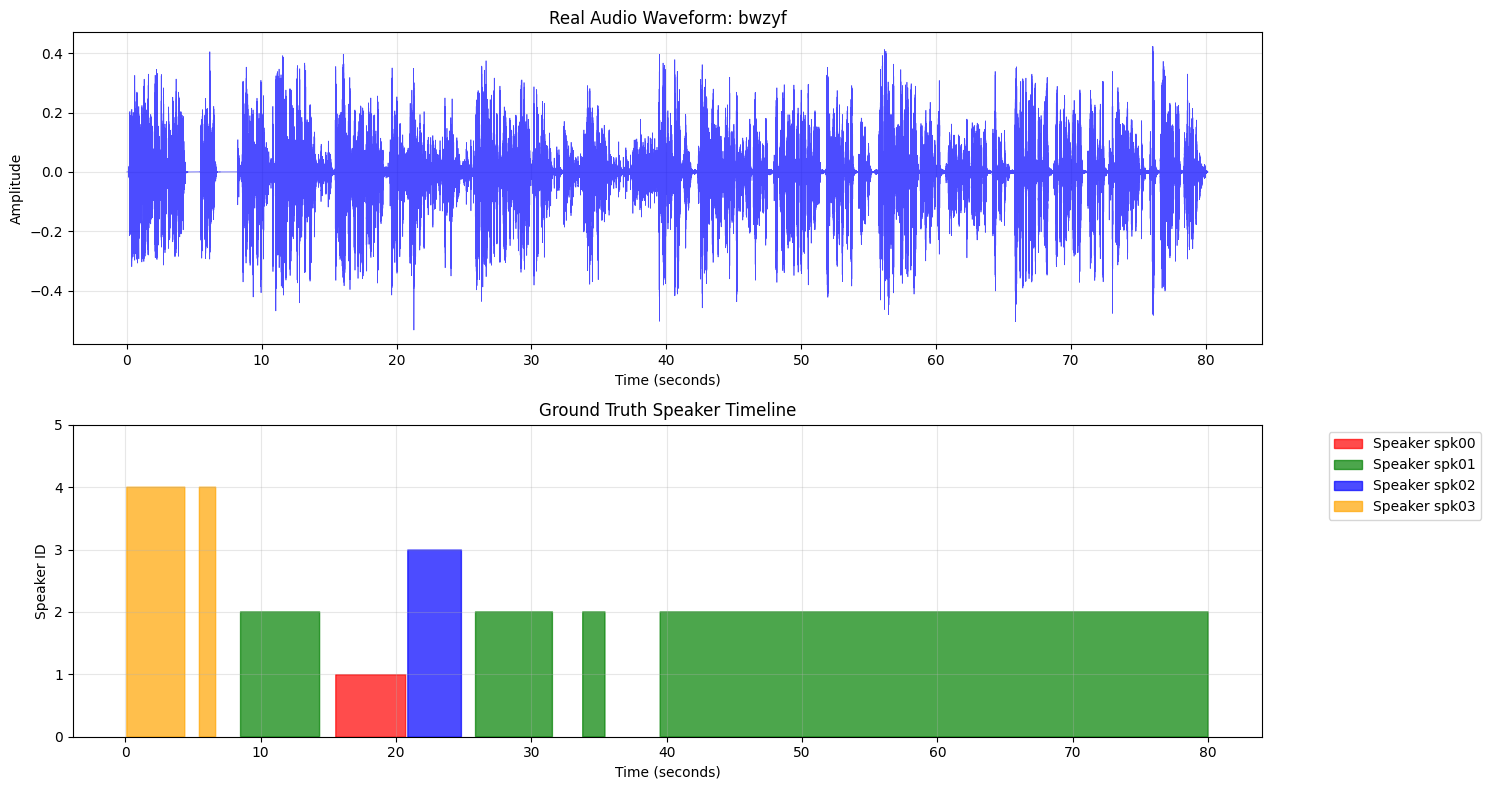

✅ Loaded audio: 80.17s, 4 speakers
   Speakers: ['spk00', 'spk01', 'spk02', 'spk03']
   Audio shape: (1282717,)

🎙️ STEP 2: Voice Activity Detection (VAD)


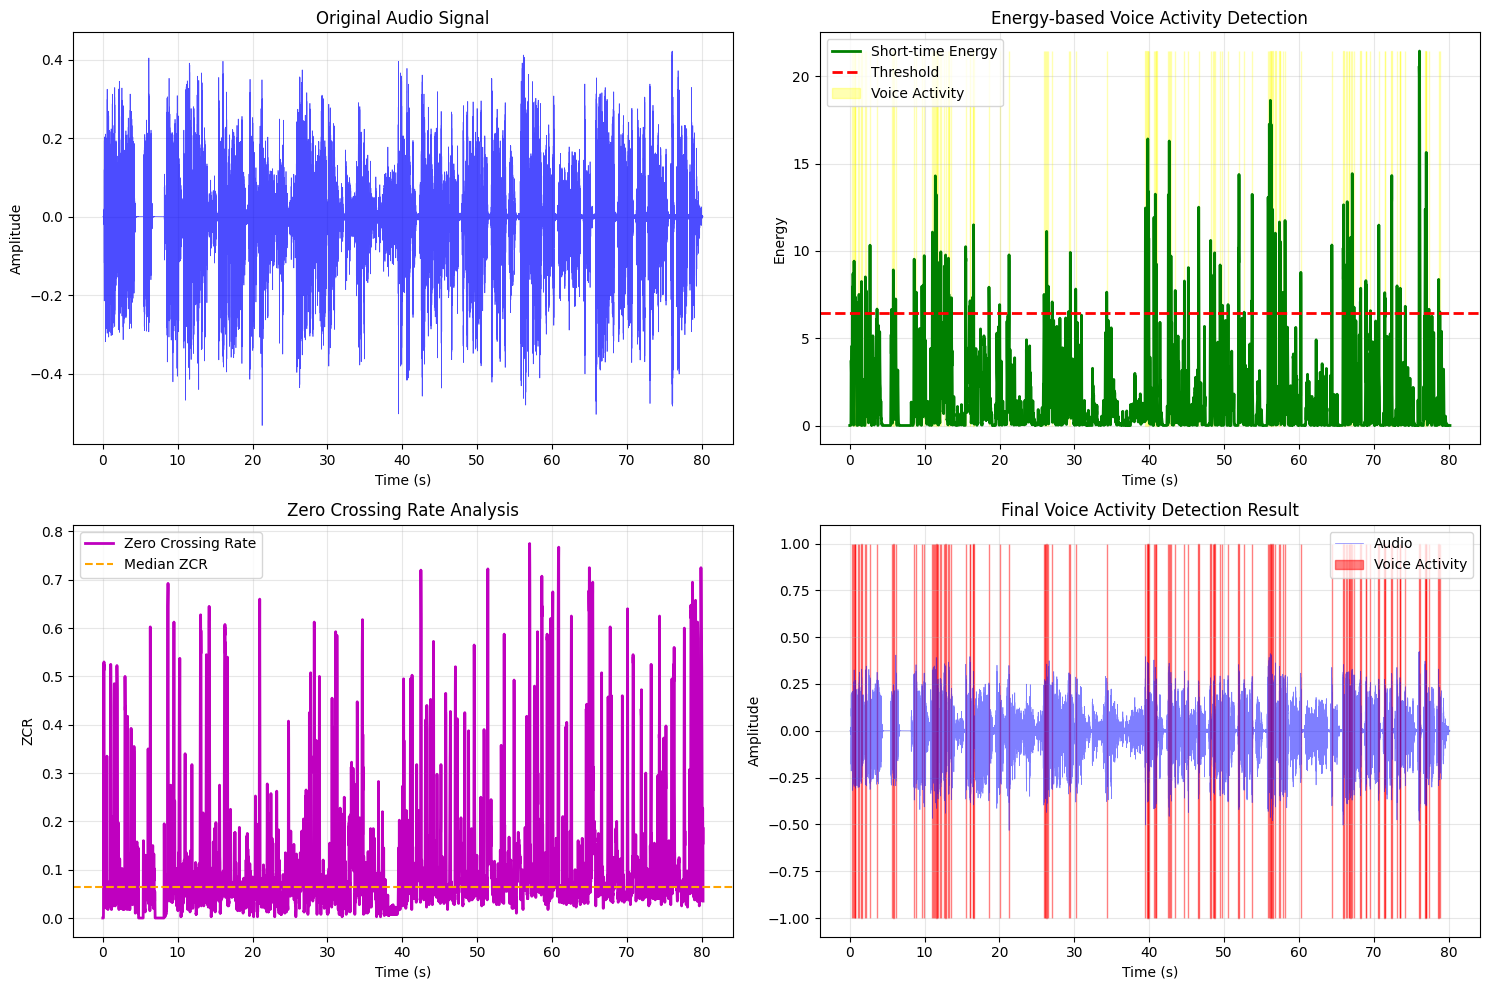

✅ Voice activity detected: 5.3% of the audio

🔍 STEP 3: Audio Feature Extraction
   Extracting features...


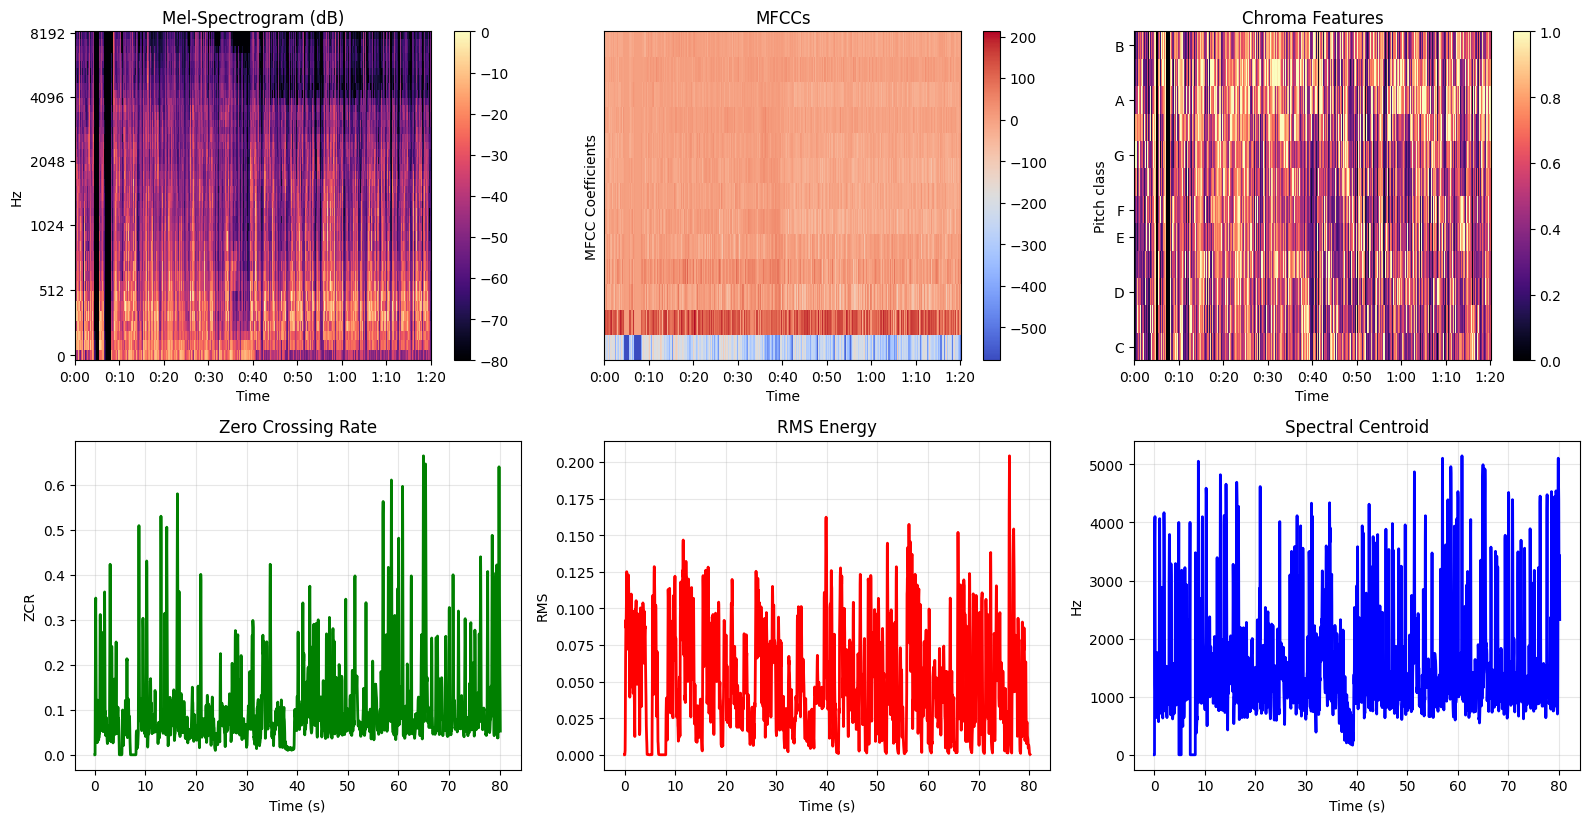

✅ Feature extraction completed
   MFCCs shape: (13, 2506)
   Feature time frames: 2506

👥 STEP 4: Creating Speaker Embeddings
✅ Speaker embeddings created
   Embedding shape: (97, 65)

🎯 STEP 5: Speaker Clustering


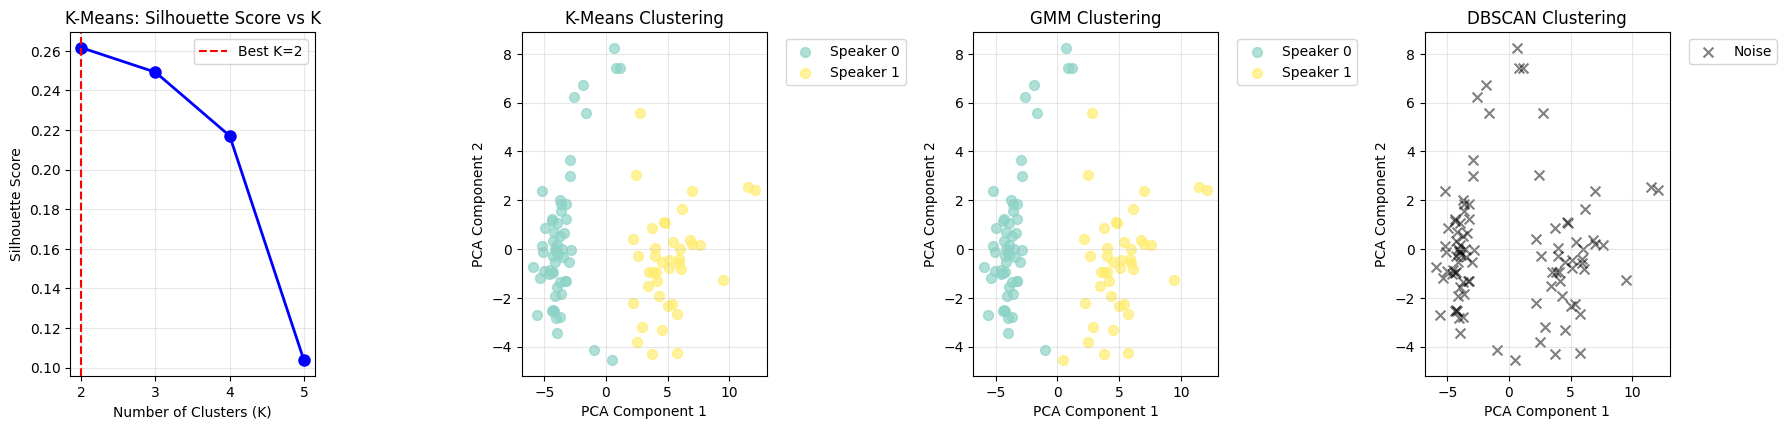

✅ Speaker clustering completed
   Best K-Means clusters: 2 (Silhouette score: 0.262)
   DBSCAN found 1 clusters

📊 STEP 6: Diarization Evaluation


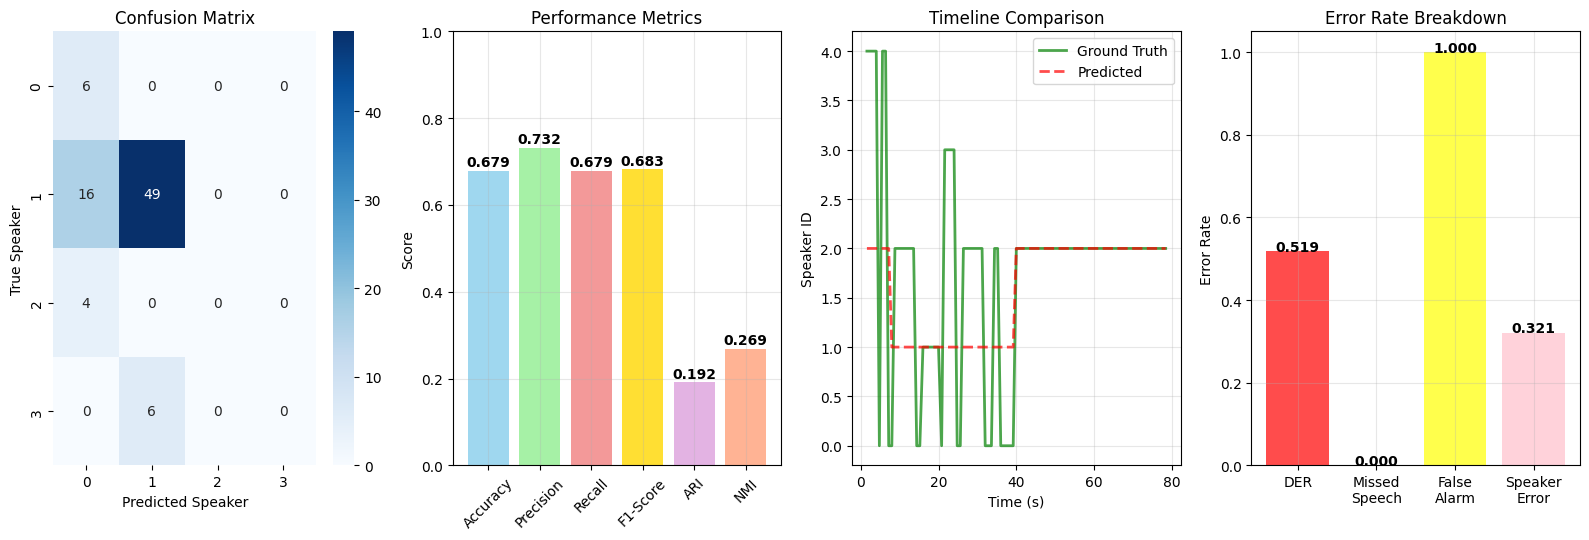

✅ Evaluation completed
   Overall Accuracy: 0.679
   F1-Score: 0.683
   Diarization Error Rate (DER): 0.519
   Adjusted Rand Index: 0.192

🎉 PIPELINE COMPLETED SUCCESSFULLY!
Summary of results:
   • Final Accuracy: 0.679
   • F1-Score: 0.683
   • Diarization Error Rate: 0.519


In [3]:
# Initialize with your dataset path
pipeline = VoxConverseDiarizationPipeline(dataset_path="/kaggle/input/voxconverse-dataset")

# Run with real data (recommended)
pipeline.run_full_pipeline(use_real_data=True, file_index=0)

# # Or try different files
# pipeline.run_full_pipeline(use_real_data=True, file_index=1)

# # Or use synthetic data for testing
# pipeline.run_full_pipeline(use_real_data=False)

# Break the step appart

📁 STEP 0: Understanding VoxConverse Dataset Structure
Checking dataset paths:
   Dev Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_dev_wav/audio
      Files found: 216
      Sample: azisu.wav
   Test Audio: ✓ /kaggle/input/voxconverse-dataset/voxconverse_test_wav/voxconverse_test_wav
      Files found: 232
      Sample: fpfvy.wav
   Labels: ✓ /kaggle/input/voxconverse-dataset/labels/dev
      Files found: 216
      Sample: bwzyf.rttm

Dataset Statistics:
   Dev audio files: 216
   Test audio files: 232
   Label files: 216

Dataset Mapping Created:
   Matched audio-label pairs: 216
   Total speaker segments: 8268
   Average speakers per recording: 4.50
   Speaker count range: 1 - 20

Sample File Analysis (bwzyf):
   Speakers: 4
   Segments: 8
   Audio duration: 80.17 seconds
   Audio shape: (1282717,)


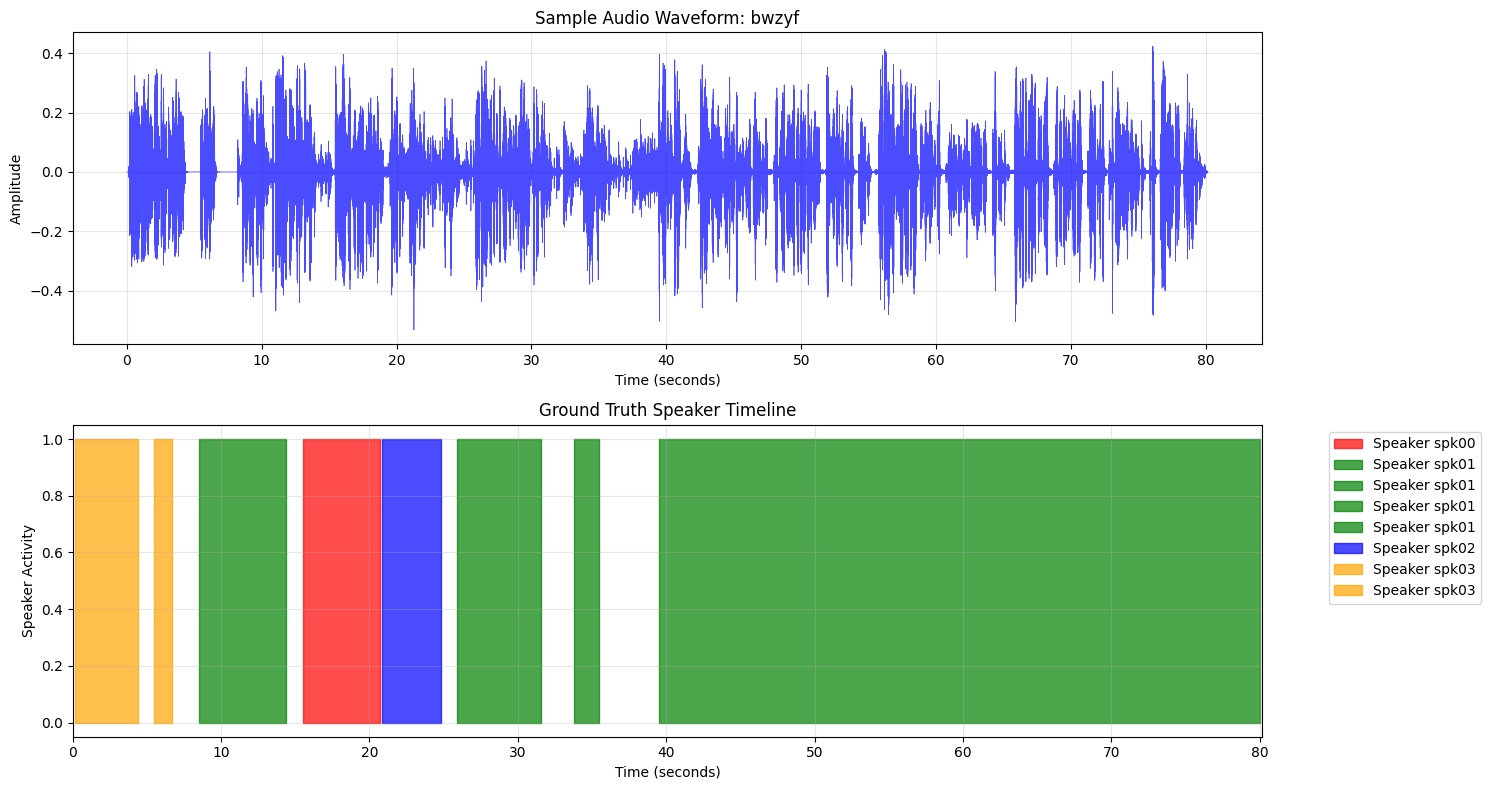


✅ Dataset structure analysis completed

🎵 STEP 1: Loading Real Audio from VoxConverse Dataset
Loading file: bwzyf


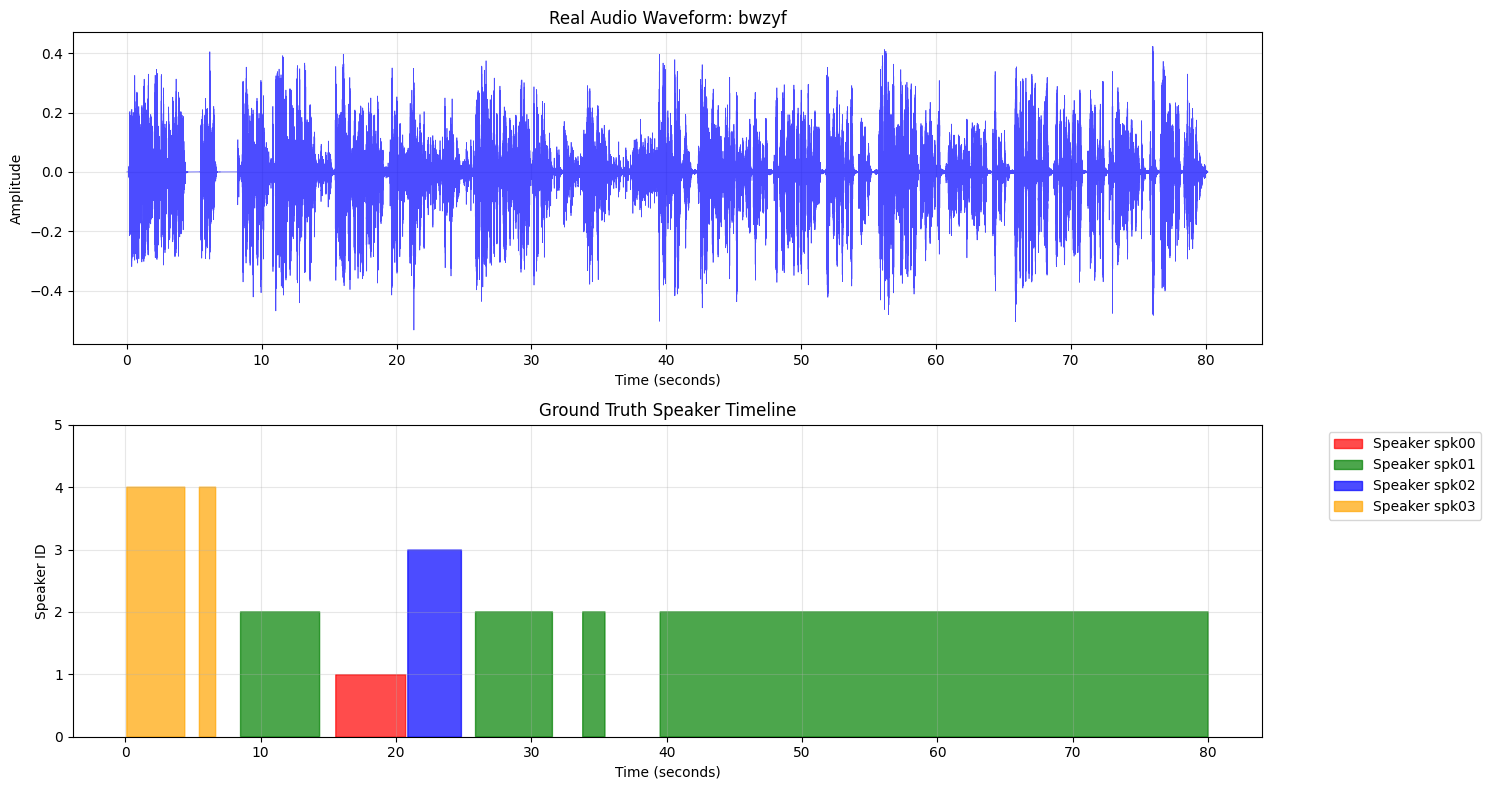

✅ Loaded audio: 80.17s, 4 speakers
   Speakers: ['spk00', 'spk01', 'spk02', 'spk03']
   Audio shape: (1282717,)

🎙️ STEP 2: Voice Activity Detection (VAD)


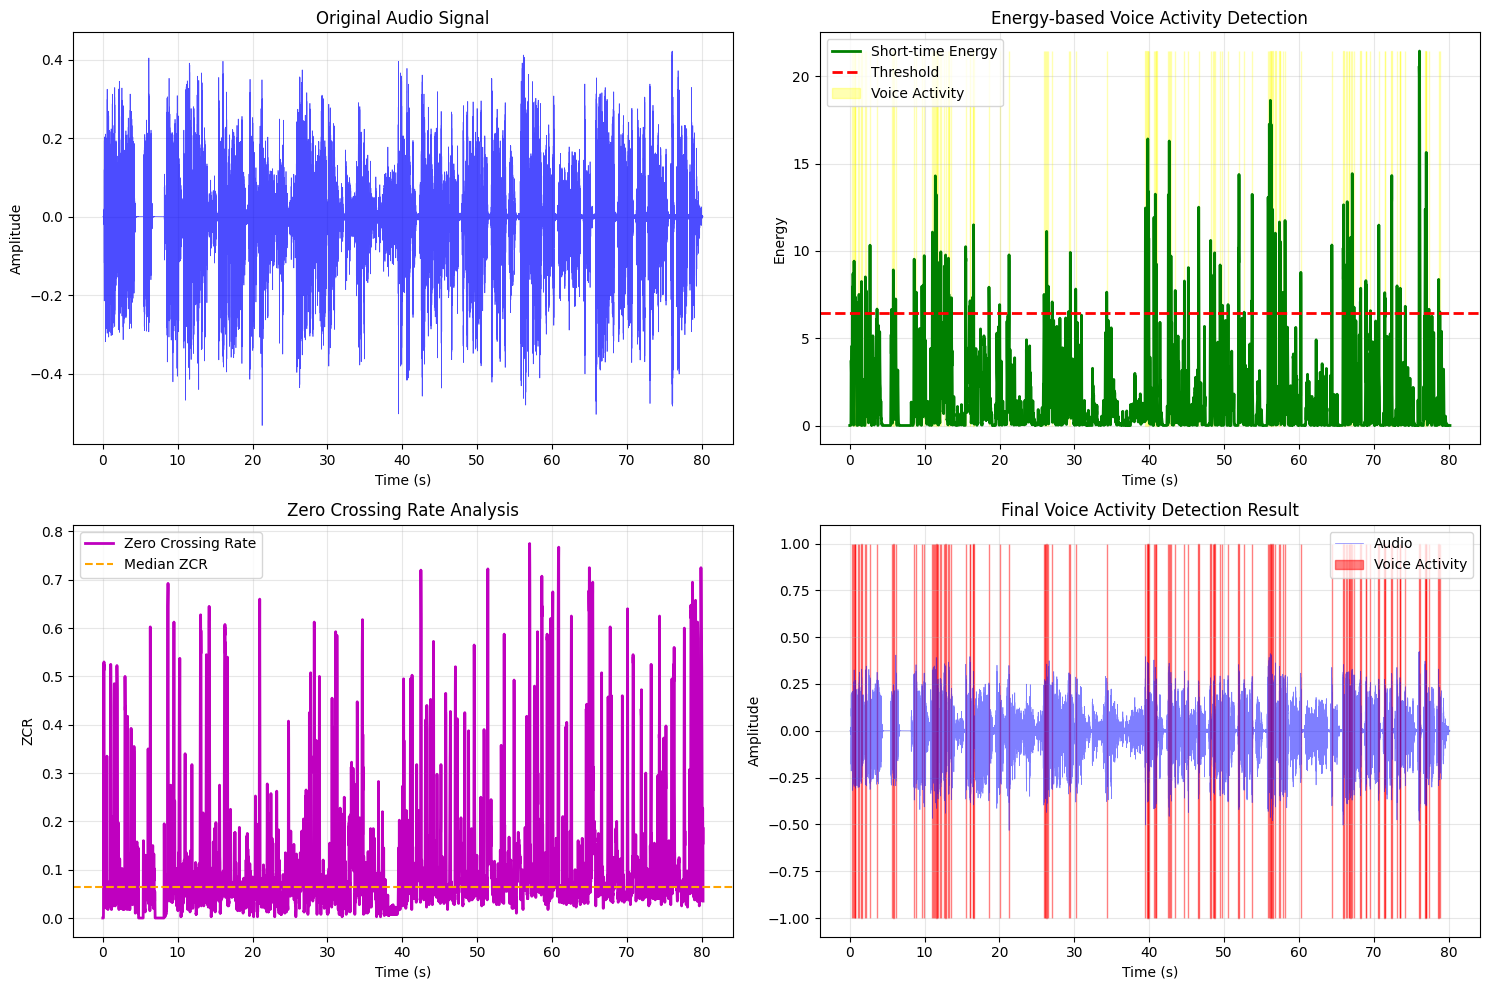

✅ Voice activity detected: 5.3% of the audio

🔍 STEP 3: Audio Feature Extraction
   Extracting features...


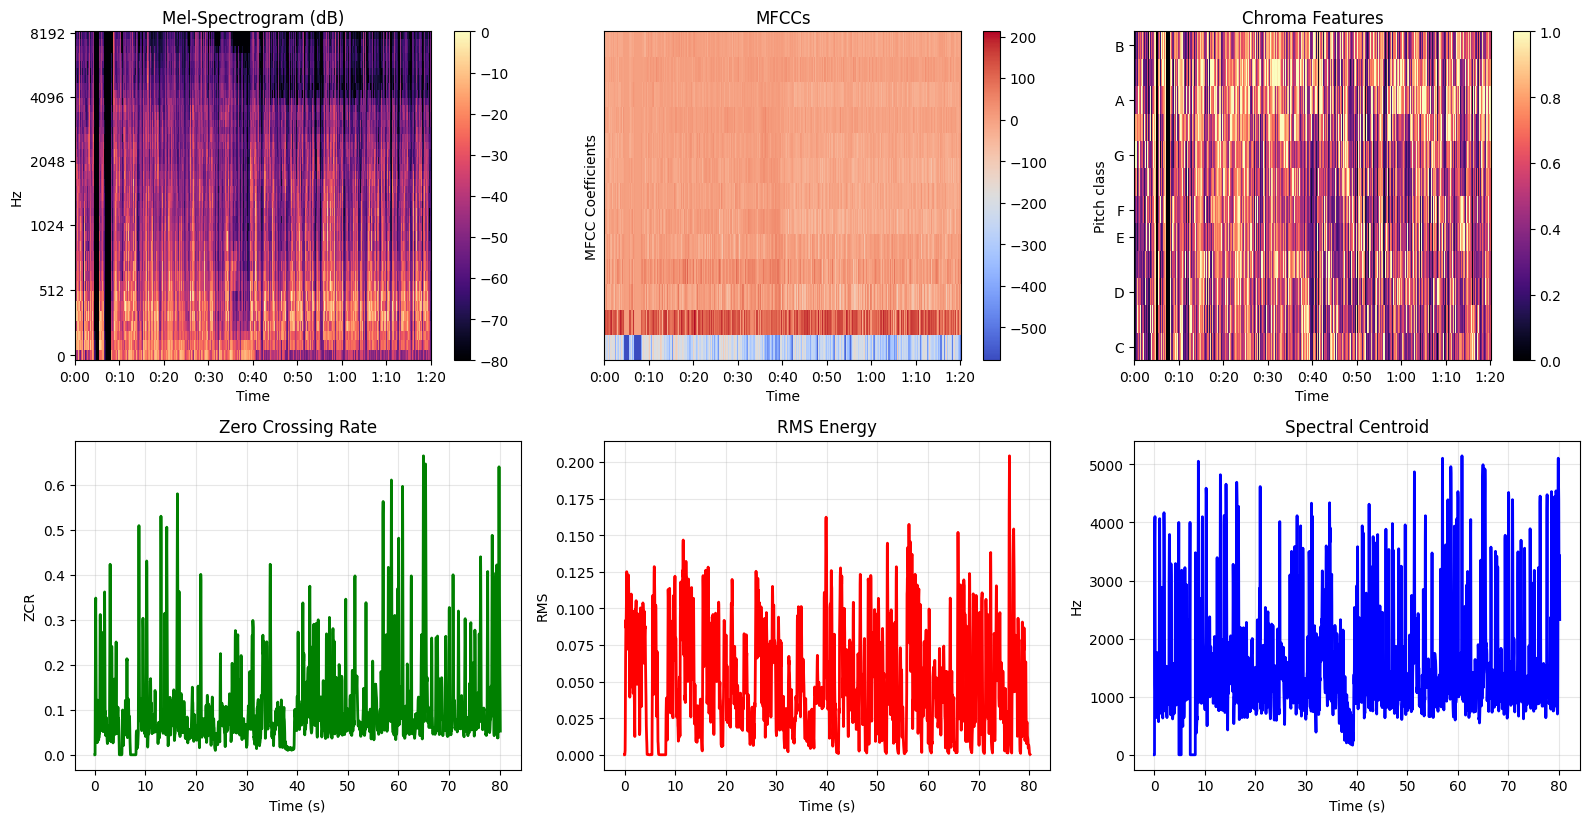

✅ Feature extraction completed
   MFCCs shape: (13, 2506)
   Feature time frames: 2506

👥 STEP 4: Creating Speaker Embeddings
✅ Speaker embeddings created
   Embedding shape: (97, 65)

🎯 STEP 5: Speaker Clustering


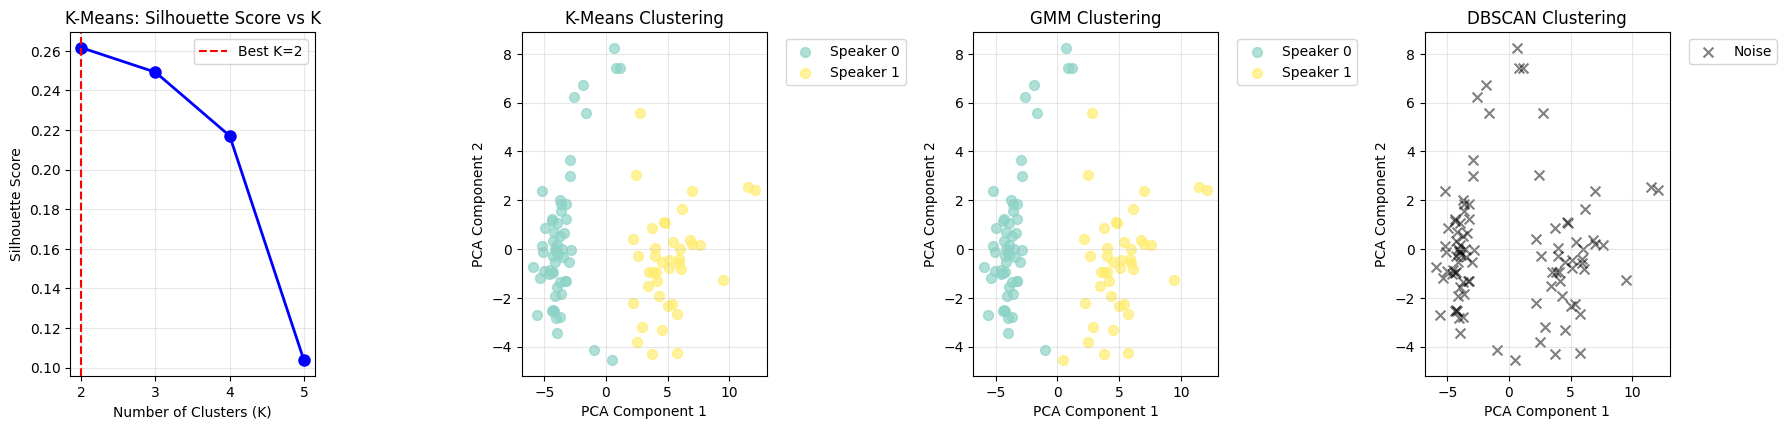

✅ Speaker clustering completed
   Best K-Means clusters: 2 (Silhouette score: 0.262)
   DBSCAN found 1 clusters


In [4]:
pipeline = VoxConverseDiarizationPipeline(dataset_path="/kaggle/input/voxconverse-dataset")

# Step 0: Analyze dataset structure and visualize a sample
pipeline.understand_dataset_structure()

# Step 1: Load one audio file or generate synthetic data
pipeline.load_real_audio(file_index=0)
# or, if dataset paths are missing:
# pipeline.generate_synthetic_data()

# Step 2: VAD
pipeline.voice_activity_detection()

# Step 3: Feature extraction
pipeline.extract_audio_features()

# Step 4: Speaker embeddings
pipeline.create_speaker_embeddings()

# Step 5: Clustering
pipeline.perform_speaker_clustering()

# Step 6: (Optional) Evaluate diarization once implemented
# pipeline.evaluate_diarization()
